In [1]:
import os
import numpy as np
import cv2, pydicom
import matplotlib.pyplot as plt

In [59]:
class Dicom():
    def __init__(self, dicom_path=None, window_center=None, window_width=None, auto=None):
        self.dicom_path = dicom_path
        self.window_center = window_center
        self.window_width = window_width
        self.auto = auto
        
        self.hu_img = self.dicom_to_array(self.dicom_path)

        self.hist, self.bins = np.histogram(self.hu_img.flatten(), \
            int(np.max(self.hu_img) - np.min(self.hu_img) + 1), [np.min(self.hu_img), np.max(self.hu_img) + 1])
        self.cdf = self.hist.cumsum()
        if auto == "all":
            clip_min = np.min(self.hu_img) + np.where(self.cdf < self.cdf[-1] * 0.02)[0][-1]
            clip_max = np.min(self.hu_img) + np.where(self.cdf > self.cdf[-1] * 0.98)[0][0]

            self.window_center = (clip_max + clip_min) / 2
            self.window_width = (clip_max - clip_min)

        if self.window_center is not None and self.window_width is not None:
            self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)
        else:
            self.img = self.hu_img

    def dicom_to_array(self, dicom_path):
        self.slice = pydicom.read_file(dicom_path)
        s = int(self.slice.RescaleSlope)
        b = int(self.slice.RescaleIntercept)
        return s * self.slice.pixel_array + b

    def get_min_max_window(self, hu_img):
        img_min = np.min(hu_img)
        img_max = np.max(hu_img)
        window_center = (img_max + img_min) / 2
        window_width = img_max - img_min
        return window_center, window_width

    def dicom_windowing(self, image, window_center, window_width):
        img_min = window_center - window_width / 2
        img_max = window_center + window_width / 2
        window_img = np.clip(image, img_min, img_max)
        return window_img
    
    def get_image(self):
        return self.img
    
    def get_hu_image(self):
        return self.hu_img
    
    def change_window(self, window_center, window_width):
        self.window_center = window_center
        self.window_width = window_width
        self.img = self.dicom_windowing(self.hu_img, self.window_center, self.window_width)
    
    def window_option(self, option):
        # (window center, width)
        options = {'brain' : (40, 80), 'soft tissues' : (40, 400), 'bone' : (400, 1800)}
        if option in options:
            self.window_center, self.window_width = options[option]
            self.change_window(self.window_center, self.window_width)
        else:
            print(f"input option : {option}, plz input right option")


In [60]:
data_list = os.listdir('data/Sample1')
dicom_path = os.path.join('data/Sample1',data_list[200])
dicom_file = Dicom(dicom_path=dicom_path, auto="all")
image = dicom_file.get_image()
hu_img = dicom_file.get_hu_image()

In [78]:
print(data_list[200])

4625.38405.33988.17340.36372.43091.37138.15103.100.279.dcm


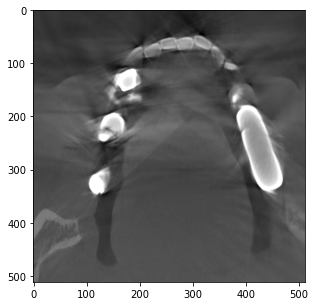

In [62]:
plt.figure(figsize=(10,5))
plt.imshow(hu_img, cmap='gray')

Text(0.5, 1.0, 'Window Center : 1064.5, Window Width : 2835')

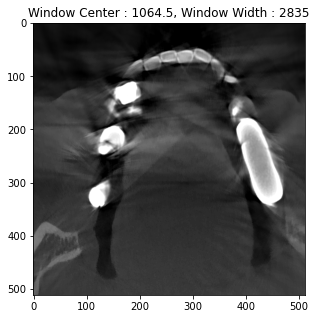

In [63]:
plt.figure(figsize=(10,5))
plt.imshow(image, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

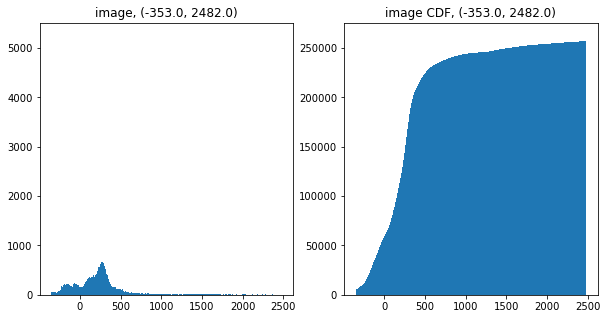

In [64]:
hist1, bins1 = np.histogram(image.flatten(), int(np.max(image) - np.min(image) + 1), [np.min(image), np.max(image) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(image.flatten(), bins1)
plt.title(f"image, {np.min(image), np.max(image)}")
plt.subplot(1, 2, 2)
plt.hist(image.flatten(), bins1, cumulative=True)
plt.title(f"image CDF, {np.min(image), np.max(image)}")
plt.show()

Text(0.5, 1.0, 'Window Center : 1066, Window Width : 2926')

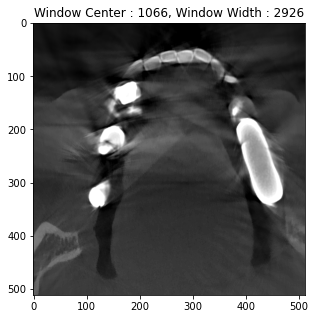

In [65]:
dicom_file.change_window(1066, 2926)
plt.figure(figsize=(10,5))
plt.imshow(dicom_file.img, cmap="gray")
plt.title(f"Window Center : {dicom_file.window_center}, Window Width : {dicom_file.window_width}")

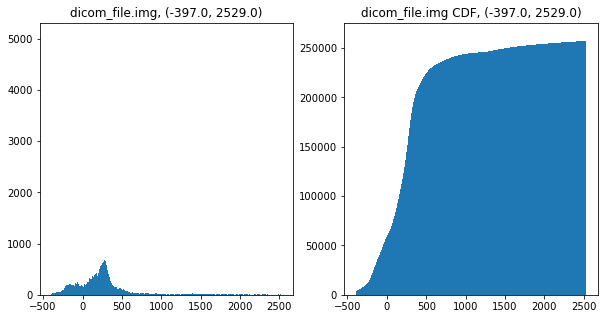

In [66]:
hist2, bins2 = np.histogram(dicom_file.img.flatten(), int(np.max(dicom_file.img) - np.min(dicom_file.img) + 1), [np.min(dicom_file.img), np.max(dicom_file.img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(dicom_file.img.flatten(), bins2)
plt.title(f"dicom_file.img, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.subplot(1, 2, 2)
plt.hist(dicom_file.img.flatten(), bins2, cumulative=True)
plt.title(f"dicom_file.img CDF, {np.min(dicom_file.img), np.max(dicom_file.img)}")
plt.show()

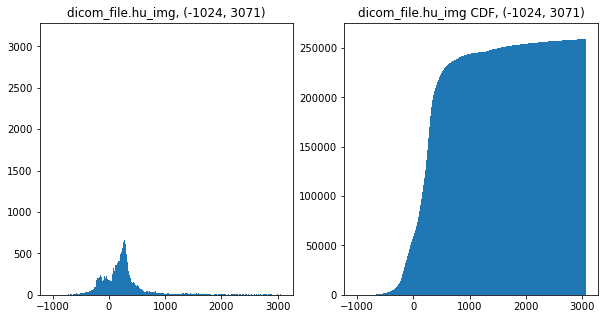

In [67]:
hist3, bins3 = np.histogram(dicom_file.hu_img.flatten(), int(np.max(dicom_file.hu_img) - np.min(dicom_file.hu_img) + 1), [np.min(dicom_file.hu_img), np.max(dicom_file.hu_img) + 1])
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(dicom_file.hu_img.flatten(), bins3)
plt.title(f"dicom_file.hu_img, {np.min(dicom_file.hu_img), np.max(dicom_file.hu_img)}")
plt.subplot(1, 2, 2)
plt.hist(dicom_file.hu_img.flatten(), bins3, cumulative=True)
plt.title(f"dicom_file.hu_img CDF, {np.min(dicom_file.hu_img), np.max(dicom_file.hu_img)}")
plt.show()

In [68]:
from scipy import stats
stats.mode(hu_img.flatten())

ModeResult(mode=array([3071], dtype=int32), count=array([3127]))

In [69]:
hu_img.mean()

301.3672409057617

In [70]:
vals,counts = np.unique(hu_img.flatten(), return_counts=True)
index = np.argmax(counts)
print(vals[index])

3071


In [71]:
np.where(counts > 700)

(array([1094, 1100, 3871], dtype=int64),)

In [72]:
counts[1094], counts[1100]

(701, 707)

In [73]:
vals[1100]

280

In [74]:
np.mean(hu_img.flatten())

301.3672409057617

In [75]:
np.median(hu_img.flatten())

226.0

In [76]:
1066 - 2926/2, 1066 + 2926/2

(-397.0, 2529.0)

In [77]:
cdf3 = hist3.cumsum()
cdf3

array([     7,      7,      8, ..., 259014, 259017, 262144], dtype=int64)

In [ ]:
np.where(cdf3 < cdf3)